## 7.8 Adam算法

1. Adam算法在RMSProp算法基础上对小批量随机梯度也做了指数加权移动平均
2. 所以Adam算法可以看做是RMSProp算法与动量法的结合

### 7.8.1 算法

1. Adam算法使用了动量变量$\boldsymbol{v}_{t}$和RMSProp算法中小批量随机梯度按元素平方的指数加权移动平均变量$\boldsymbol{s}_{t}$,时间步0初始化为0

2. 给定超参数$0 \leq \beta_1 < 1$(建议设置为0.9),时间步$t$的动量变量$\boldsymbol{v}_{t}$和小批量随机梯度$\boldsymbol{g}_{t}$的指数加权平均

$$\boldsymbol{v}_{t} \leftarrow \beta_1 \boldsymbol{v}_{t-1} + (1 - \beta_1) \boldsymbol{g}_{t}$$

3. 给定超参数$0 \leq \beta_1 < 1$(建议设置为0.999),将小批量随机梯度按元素平方后的项$\boldsymbol{g}_{t} \odot \boldsymbol{g}_{t}$做指数加权移动平均

$$\boldsymbol{s}_{t} \leftarrow \beta_2 \boldsymbol{s}_{t-1} + (1 - \beta_2) \boldsymbol{g}_{t} \odot \boldsymbol{g}_{t}$$

4. $\boldsymbol{v}_{0}$和$\boldsymbol{s}_{0}$的元素均初始化为0,时间步$t$可得,$\boldsymbol{v}_{t} = (1 - \beta_1) \sum_{i=1}^t \beta_1^{t-i} \boldsymbol{g}_{i}$,将梯度系数求和$(1-\beta_1)\sum_{i=1}^{t}\beta_1^{t-i} = 1 - \beta_1^t$

5. 当$t$比较小时,过去各时间步小批量随机梯度权值之和会较小,为了消除此影响,可将$v_{t}$在除以$1-\beta^t$,这样过去各时间步小批量随机梯度权值之和为1,也叫做作偏差修正

$$\hat{\boldsymbol{v}_{t}} \leftarrow \frac{\boldsymbol{v}_{t}}{1 - \beta_1^t}$$


$$\hat{\boldsymbol{s}_{t}} \leftarrow \frac{\boldsymbol{s}_{t}}{1 - \beta_2^t}$$


6. 将模型参数中每个元素的学习率通过按元素运算重新调整

$$\boldsymbol{g'}_{t} \leftarrow \frac{\eta \hat{\boldsymbol{v}_{t}}}{\sqrt{\hat{\boldsymbol{s}_{t}}}+\epsilon}$$

其中$\eta$是学习率,$\epsilon$是维持数值稳定性而添加的常数，如$10^{-8}$,最后使用$\boldsymbol{g'}_{t}$迭代

$$\boldsymbol{x}_{t} \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g'}_{t}$$

In [3]:
%matplotlib inline
import torch
import sys
sys.path.append("..") 
import d2lzh_pytorch.utils as d2l

In [4]:
features, labels = d2l.get_data_ch7()

def init_adam_states():
    v_w, v_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    s_w, s_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    return ((v_w, s_w), (v_b, s_b))


def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        v[:] = beta1 * v + (1 - beta1) * p.grad.data
        s[:] = beta2 * s + (1 - beta2) * (p.grad.data**2)
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        p.data -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)
    hyperparams['t'] += 1

loss: 0.243668, 0.105752 sec per epoch


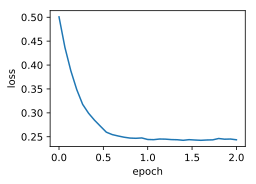

In [5]:
d2l.train_ch7(adam, init_adam_states(), {'lr': 0.01, 't': 1}, features, labels)

### 7.8.3 简洁实现

loss: 0.242679, 0.075797 sec per epoch


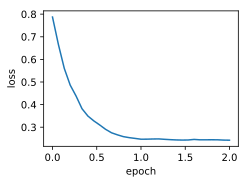

In [6]:
d2l.train_pytorch_ch7(torch.optim.Adam, {'lr': 0.01}, features, labels)